In [51]:
%load_ext autoreload
%autoreload 2
import torch
import json
import numpy as np
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [53]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
model.max_seq_length = 512

In [54]:
train = "/dfs/scratch1/gmachi/datasets/WikiSection/wikisection_en_disease_train.json"
with open(train, 'r') as f:
    train_data = json.load(f)

save_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/"
save_path_Zs = os.path.join(save_path, "train")

In [55]:
target = "disease.treatment" # class-1

In [56]:
section_labs = {}
section_pseudo = {}
doc_labs = {}
for i in range(len(train_data)):
    text = train_data[i]["text"]
    annots = train_data[i]["annotations"]
    labs = []
    pseudos = []
    embeds = []

    for annot in annots:
        idx = [int(annot["begin"]), int(annot["length"])]
        chunk = text[idx[0]:idx[1]]
        embeds.append(model.encode(chunk))
        pseudo = annot["sectionLabel"]
        pseudos.append(pseudo)
        lab = 0
        if pseudo == target:
            lab = 1
        labs.append(lab)
    
    doc_lab = int(np.sum(labs))
    doc_labs[i] = doc_lab
    Z = np.stack(embeds)
    Z_name = "doc_"+str(i)+"_class_"+str(doc_lab)+".npy"
    save_path_Z = os.path.join(save_path_Zs, Z_name)
    np.save(save_path_Z, Z)
    section_pseudo[i] = pseudos
    section_labs[i] = labs

In [57]:
np.sum(list(doc_labs.values()))

2726

In [58]:
from utils import serialize

In [59]:
save_path_doc_labs = os.path.join(save_path, "train-doc-labs.obj")
serialize(doc_labs, save_path_doc_labs)
save_path_sec_pseudo = os.path.join(save_path, "train-sec-pseudo.obj")
serialize(section_pseudo, save_path_sec_pseudo)
save_path_sec_labs = os.path.join(save_path, "train-sec-labs.obj")
serialize(section_labs, save_path_sec_labs)

# sample embeddings + build map graphs

In [74]:
from utils import convert_text2graph
import random
from utils import deserialize
import networkx as nx

In [65]:
save_path_Gs = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_Gs"

We sample 2 embeddings from each training sample to give us ~5k embeddings

In [80]:
embeds_sample = []
for save_path_Z in os.listdir(save_path_Zs):
    Z_file = os.path.join(save_path_Zs, save_path_Z)
    Z = np.load(Z_file)

    # sample
    l = Z.shape[0]
    try:
        ids = random.sample(range(l),2)
    except ValueError: #l == 1:
        ids = [0] 
    embeds = [Z[i,:] for i in ids]
    embeds_sample.extend(embeds)

    # convert to graph
    G = convert_text2graph(Z)
    G_file = save_path_Z.split(".")[0] + "_graph.obj"
    save_path_G = os.path.join(save_path_Gs, G_file)
    serialize(G, save_path_G)



Confirm topology!

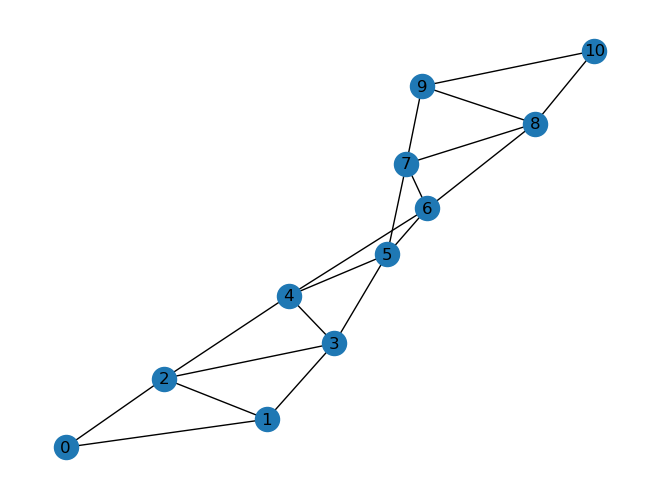

In [76]:
G_saved = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_Gs/doc_1107_class_1_graph.obj"
G = deserialize(G_saved)
nx.draw(G, with_labels = True)

In [84]:
embed_array = np.stack(embeds_sample)
embed_array.shape
save_path_meta = "/dfs/scratch1/gmachi/datasets/wikisection_processed"
save_path_embed = os.path.join(save_path_meta, "embed_sample.obj")
serialize(embed_array, save_path_embed)